### Imports & Preparation

In [13]:
import sys
sys.path.insert(1, '../')  # to load from any submodule in the repo

import utils.readOBJ as reader
import utils.dpcr_utils as utils
import utils.dpcr_generator as generator

#import models3D.neighbor_predictor3D as neighbor_predictor3D
import models.predictor_bn as neighbor_predictor3D
import models3D.detector3D as detector3D

import torch
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
import itertools
import _pickle as cPickle

device = torch.device("cpu")

if torch.device("cuda"):
    device = torch.device("cuda")
    print("Using", torch.cuda.device_count(), "CUDA devices")
    
torch.no_grad()

seed_file = open('../utils/seed.txt', "r")
seed = int(seed_file.read())
seed_file.close()

print ("Using Seed:", seed)
    
torch.manual_seed(seed)
np.random.seed(seed)

Using 1 CUDA devices
Using Seed: 34897567


### Checkpoint Loading

In [14]:
predictor = neighbor_predictor3D.Model(k = 20, emb_dims = 1024, dropout = 0.5, neighbors = 6).to(device)
predictor = torch.nn.DataParallel(predictor)

detector = detector3D.Model(k = 10, emb_dims = 1024, dropout = 0.5).to(device)
detector = torch.nn.DataParallel(detector)

predictor_checkpoint = torch.load('../models3D/predictor_bn_model_e11.t7')
detector_checkpoint = torch.load('../models3D/model_detector_3d_batched_e50.t7')

predictor.load_state_dict(predictor_checkpoint['model_state_dict'][2])
print ("> Loaded predictor model (%d epochs)" % len(predictor_checkpoint['train_time']))

detector.load_state_dict(detector_checkpoint['model_state_dict'])
print ("> Loaded detector model (%d epochs)" % detector_checkpoint['epoch'])

_ = predictor.eval()
_ = detector.eval()



> Loaded predictor model (11 epochs)
> Loaded detector model (50 epochs)


### Test Model Generation

In [3]:
start = time.time()

model, _ = reader.readOBJ('../data/models/faces/clean/face_12_clean.obj')
model = np.array(model).astype(float)

pts_tensor = torch.from_numpy(model).float().to(device)

# mean centering
pts_tensor = pts_tensor - torch.mean(pts_tensor, dim = 0)

min_vals, _ = torch.min(pts_tensor, dim = 0)
max_vals, _ = torch.max(pts_tensor, dim = 0)
scale = torch.max(torch.abs(min_vals),  torch.abs(max_vals))

# scale to fit 2x2x2 bounding box
pts = pts_tensor / scale

knn = utils.knn(pts_tensor, 6)

val_data = generator.getData(pts_tensor, 20)

print ("Generated %d Test Models" % len(val_data))
print ("Total Time:", time.time() - start)

Generated 174 Test Models
Total Time: 5.40399956703186


In [4]:
train_data = None
with open('../data/train_test_data_new/train_data_test', 'rb') as file:
    train_data = cPickle.load(file)

In [5]:
pts = train_data["pts"].float().to(device)
knn = train_data["knn"]

train_bins = train_data["train_bins"]
test_samples = train_data["test_samples"]

In [6]:
neighbors_dirs = pts[knn] - pts[:, None, :]

perms_np = np.array(list(itertools.permutations(np.arange(6))))
perms = torch.from_numpy(perms_np).long().to(device)

neighbors_dirs_perms = torch.zeros((neighbors_dirs.size(0), perms.size(0), 6, 3), device=device)

for (i, p) in enumerate(perms):
    neighbors_dirs_perms[:,i] = neighbors_dirs[:, p, :]

In [7]:
cum_test_loss = 0
loss_function = torch.nn.MSELoss(reduction='sum')

for sample in test_samples:

    sample_ids = sample[:,0].flatten()

    p = predictor(pts[sample_ids].unsqueeze(0).transpose(1,2))  # size: (1, 3*NC, N)
    p = p.squeeze(0)                                        # size: (3*NC, N)
    p = p.transpose(0,1)                                    # size: (N, 3*NC)
    p = p.reshape((-1, 6, 3))                 # size: (N, NC, 3)

    t_perm = neighbors_dirs_perms[sample_ids]                 # size: (N, perm_count, NC, 3)

    # for each vertex compute a permutation of neighbors s.t. the sum of differences to the prediction is minimized
    minmatches = utils.matchPoints(p.detach(), y=None, perms=perms, y_perms=t_perm)  # size: (N, NC)

    # expand the permutation index
    gather_idx = minmatches.expand(3,minmatches.size(0),minmatches.size(1)).transpose(0,1).transpose(1,2)  # size: (N, NC, 3)

    # gather neighbor directions according to the permutations
    t = neighbors_dirs[sample_ids].gather(1, gather_idx)    # size: (N, NC, 3)
    
    cum_test_loss += loss_function(p, t).item()
    
print ("Average Validation Loss: %.3f" % (cum_test_loss / len(val_data)))

RuntimeError: CUDA out of memory. Tried to allocate 352.00 MiB (GPU 0; 8.00 GiB total capacity; 4.71 GiB already allocated; 217.55 MiB free; 1.32 GiB cached)

torch.Size([6592])
torch.Size([1, 3, 6592])
torch.Size([6, 3])
tensor([2, 0, 3, 4, 1, 5], device='cuda:0')
tensor([[ 0.0068, -0.0046,  0.0245],
        [ 0.0244,  0.0150,  0.0133],
        [-0.0079,  0.0052, -0.0242],
        [-0.0252, -0.0135, -0.0124],
        [-0.0169, -0.0189,  0.0126],
        [ 0.0165,  0.0203, -0.0117]], device='cuda:0')
torch.Size([72488, 3])


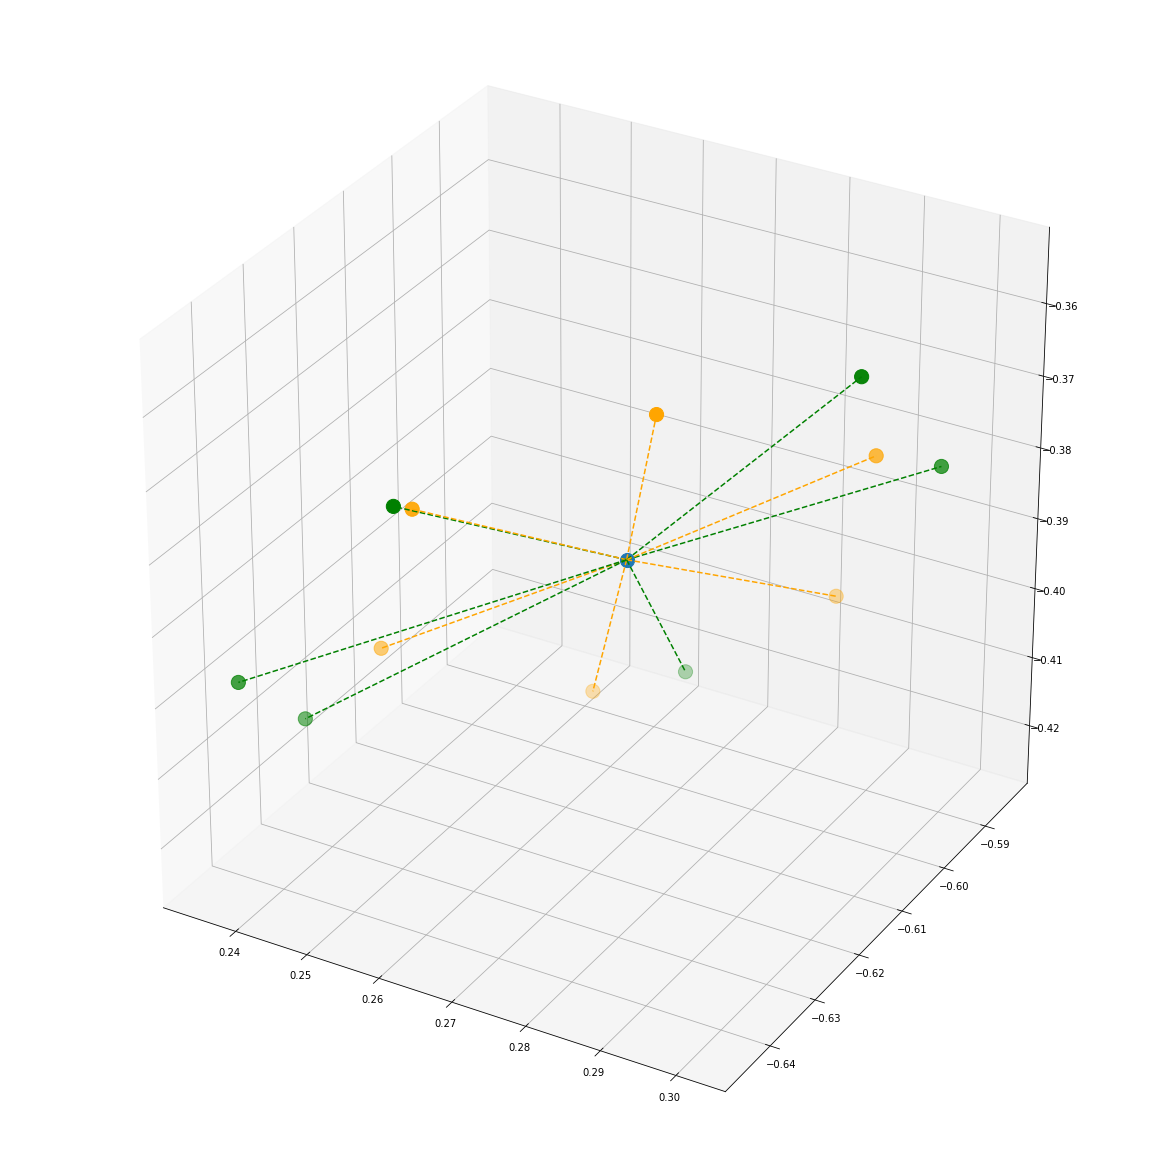

In [25]:
fig = plt.figure(figsize=(16,16))
ax = Axes3D(fig)

sample_ids = val_data[np.random.randint(len(val_data))][:,0].flatten()

print (sample_ids.size())

input_tensor = pts[sample_ids].unsqueeze(0).transpose(1,2)

print (input_tensor.size())

p = predictor(pts[sample_ids].unsqueeze(0).transpose(1,2))
p = p.squeeze(0)                                        # size: (3*NC, N)
p = p.transpose(0,1)                                    # size: (N, 3*NC)
p = p.reshape((-1, 6, 3))                 # size: (N, NC, 3)

ex_id = np.random.randint(p.size(0))

ex_p = p[ex_id].detach()
re_p = neighbors_dirs[sample_ids[ex_id]].detach()

print (ex_p.size())

perm = utils.matchPoints(ex_p.unsqueeze(0), re_p.unsqueeze(0)).reshape(-1)

print (perm)
print (ex_p)
ex_p = ex_p[perm] 
print (pts.size())

ex_p_numpy = ex_p.clone().detach().cpu().numpy()
re_p_numpy = re_p.clone().detach().cpu().numpy()

sample = pts_tensor[val_data[np.random.randint(len(val_data))][:,0]]

numpy_sample = sample.clone().detach().cpu().numpy()

op = pts[sample_ids[ex_id]].flatten().detach().cpu().numpy()
pp = ex_p_numpy + op
rp = re_p_numpy + op

ax.scatter(op[0],op[1],op[2], s=200)
ax.scatter(pp[:,0], pp[:,1], pp[:,2], s=200,color='orange')
ax.scatter(rp[:,0], rp[:,1], rp[:,2], s=200,color='green')

for i in range(re_p_numpy.shape[0]):
    x = np.array([rp[i,0],pp[i,0]])
    y = np.array([rp[i,1],pp[i,1]])
    z = np.array([rp[i,2],pp[i,2]])
    #ax.plot(x,y,z,'black')
    x = np.array([op[0],pp[i,0]])
    y = np.array([op[1],pp[i,1]])
    z = np.array([op[2],pp[i,2]])
    ax.plot(x,y,z,'black',color='orange',linestyle='--')
    x = np.array([op[0],rp[i,0]])
    y = np.array([op[1],rp[i,1]])
    z = np.array([op[2],rp[i,2]])
    ax.plot(x,y,z,'black',color='green',linestyle='--')

plt.show()

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = Axes3D(fig)

sample = pts_tensor[val_data[np.random.randint(len(val_data))][:,0]]

numpy_sample = sample.clone().detach().cpu().numpy()

ax.scatter(numpy_sample[:,0], numpy_sample[:,1], numpy_sample[:,2])

plt.show()

In [ ]:
def getNewValidNeighbors(sample, new_pts):

    # compute minimum distance to next point for all sample points
    aa = torch.sum(sample**2, dim=1, keepdim=True)
    bb = torch.sum(sample**2, dim=1, keepdim=True)
    ab = torch.matmul(sample, sample.transpose(0, 1))

    D = aa - 2.0 * ab + bb.transpose(0, 1)

    # min_rad for each point is equal to half the distance to its nearest neighbor
    min_rad = 0.9 * D.topk(k=2, dim=1, largest=False)[0][:,1:]
    
    # compute distance from new point candidates to existing points
    aa = torch.sum(new_pts**2, dim=1, keepdim=True)
    bb = torch.sum(sample**2, dim=1, keepdim=True)
    ab = torch.matmul(new_pts, sample.transpose(0, 1))

    D_neigh = aa - 2.0 * ab + bb.transpose(0, 1)

    # mask of {0,1} where 0 indicates that a new point is not too close to an existing point
    mask = torch.max(D_neigh < min_rad.transpose(0,1), dim=1)[0]
    
    # merge clusters for new points
    new_pts = utils.mergeClusters(new_pts[mask == 0], torch.mean(min_rad))
    
    return new_pts

In [ ]:
arr = []

runnning_sample = sample.clone().detach()

print (runnning_sample.size())

for i in range(10):
    
    print ("Iteration %d:" % (i+1))
    
    rs = runnning_sample.to(device)
    
    input = rs.unsqueeze(0).transpose(1,2)
    
    p = predictor(input).squeeze(0).transpose(0,1).reshape((-1, 6, 3))
    e = detector(input).squeeze(0).transpose(0,1).argmax(dim=1)
    
    # add predicted neighbor directions (p) to the given input points (rs) and select those,
    # where an edge is predicted (e == 1)
    newNeighbors = (p + rs[:, None, :])[e == 1]
    
    newPoints = torch.zeros((newNeighbors.size(0) * newNeighbors.size(1), 3), device = newNeighbors.device, requires_grad=False)
    for i in range(newNeighbors.size(0)):
        for k in range(newNeighbors.size(1)):
            newPoints[newNeighbors.size(1) * i + k] = newNeighbors[i,k]
            
    newPoints = getNewValidNeighbors(rs, newPoints)
    
    arr.append(newPoints.clone().detach().cpu().numpy())
    
    runnning_sample = torch.cat([runnning_sample.detach().cpu(), newPoints.detach().cpu()])
    
    print ("New Pts:", newPoints.size(0))
    print ("New Size:", runnning_sample.size(0))

    del p, e, newNeighbors, input, rs

    if (newPoints.size(0) < 1):
        break
        
    del newPoints
    torch.cuda.empty_cache()
    
torch.cuda.empty_cache()

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = Axes3D(fig)

numpy_sample = sample.clone().detach().cpu().numpy()

ax.scatter(numpy_sample[:,0], numpy_sample[:,1], numpy_sample[:,2])

for i in range(len(arr)):
    pts_numpy = arr[i]
    fac = (i+1) / len(arr)
    ax.scatter(pts_numpy[:,0], pts_numpy[:,1], pts_numpy[:,2],
                label=('iteration ' + str(i+1)),
                color = matplotlib.cm.get_cmap('viridis')(fac))
    
plt.legend()

fig = plt.figure(figsize=(16,16))
ax = Axes3D(fig)

ax.scatter(numpy_sample[:,0], numpy_sample[:,1], numpy_sample[:,2])

In [ ]:
colors = sample.shape[0] * [200 * np.ones(3, dtype=np.int)]
data = sample.cpu().numpy().tolist()

for i in range(len(arr)):
    for k in range(arr[i].shape[0]):
        data.append(arr[i][k])
        colors.append(np.array(matplotlib.cm.get_cmap('viridis')((i+1) / len(arr)))[:3] * 255)

data = np.array(data)
colors = np.array(colors).astype(np.int)
        
print (colors.shape)
print (data.shape)

utils.exportPLY(data, colors, "D:\\Github\\Repos\\dpcr\\evaluation", name = 'output_model')